<a href="https://colab.research.google.com/github/fredyvelasquezgt/Lab-9-DL/blob/main/lab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 9 - Deep Learning

Autores

- Angel Higueros 20460
- Fredy Velasquez 2010111

### Task 1 - Práctica

1. Preparacion de datos

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [8]:
data_path = "/content/train.csv"

data = pd.read_csv(data_path)

In [9]:
# Verificando valores nulos
print(data.isnull().sum())

date     0
store    0
item     0
sales    0
dtype: int64


In [10]:
# Convertir la columna 'date' a datetime
data['date'] = pd.to_datetime(data['date'])

# Escalado de la columna 'sales'
scaler = MinMaxScaler(feature_range=(0, 1))
data['sales'] = scaler.fit_transform(data[['sales']])

2. Preparacion de datos

In [11]:
# Asumiendo que 'data' es tu DataFrame y ya has realizado la limpieza y escalado
train_data = data[data['date'] < '2016-01-01']
test_data = data[data['date'] >= '2016-01-01']

# Debes asegurarte de que solo estés trabajando con la columna que deseas predecir, en este caso, 'sales'
train_data = train_data[['sales']].values
test_data = test_data[['sales']].values


In [12]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [13]:
window_size = 60  # Por ejemplo, usar los 60 puntos de datos anteriores para predecir el siguiente

# Crear secuencias para entrenamiento
X_train, y_train = create_sequences(train_data, window_size)

# Crear secuencias para prueba
X_test, y_test = create_sequences(test_data, window_size)

# Es importante que los datos estén en la forma correcta para alimentar a la LSTM
# Reshape [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Dividir los datos de entrenamiento para crear un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


3. Seleccion de modelo

- Se usara LSTM

4. Arquitectura del modelo

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Salida de una unidad para la predicción de ventas

model.compile(optimizer='adam', loss='mean_squared_error')


5. Entrenamiento del modelo

In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
13686/13686 [==============================] - 414s 30ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/50
13686/13686 [==============================] - 406s 30ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 3/50
13686/13686 [==============================] - 404s 30ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/50
13686/13686 [==============================] - 403s 29ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/50
13686/13686 [==============================] - 404s 29ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/50
13686/13686 [==============================] - 404s 30ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/50
13686/13686 [==============================] - 404s 29ms/step - loss: 0.0013 - val_loss: 9.8134e-04
Epoch 8/50
13686/13686 [==============================] - 403s 29ms/step - loss: 0.0013 - val_loss: 9.8694e-04
Epoch 9/50
13686/13686 [==============================] - 404s 30ms/step - loss: 0.0013 - val_loss: 9.9559e-04
Epoch 10/50
13686/13686 [

In [ ]:
model.save('my_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo
new_model = load_model('my_model.keras')

In [ ]:
# Evaluar el modelo con datos de prueba
loss = new_model.evaluate(X_test, y_test)
print(f"Loss: {loss}")

11420/11420 [==============================] - 117s 10ms/step - loss: 0.0014
Loss: 0.001352919964119792


In [ ]:
predicted_sales = new_model.predict(X_test)

11420/11420 [==============================] - 116s 10ms/step


In [ ]:
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Realizar predicciones en el conjunto de test
predictions = new_model.predict(X_test)


# Calcular las métricas de evaluación
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # La raíz cuadrada del MSE es el RMSE

# Imprimir las métricas
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


11420/11420 [==============================] - 118s 10ms/step
MAE: 0.028124939863277777
MSE: 0.0013529171084681877
RMSE: 0.03678202153862927


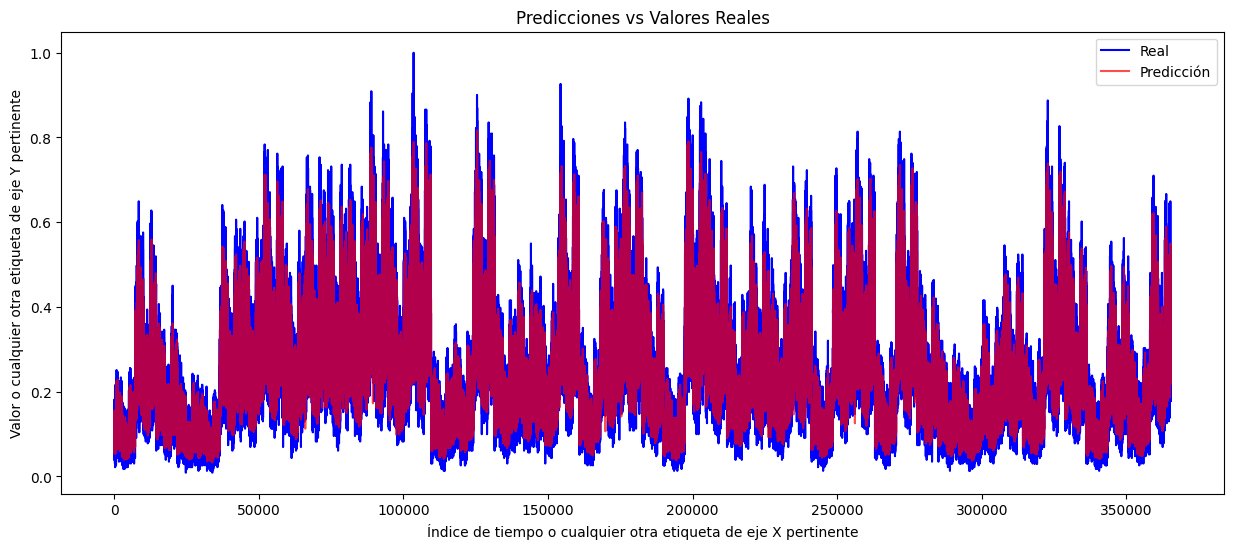

In [ ]:
# Crear una figura y un set de subplots
plt.figure(figsize=(15,6))

# Dibujar los valores reales
plt.plot(y_test, color='blue', label='Real')

# Dibujar las predicciones
plt.plot(predictions, color='red', alpha=0.7, label='Predicción')

# Títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Índice de tiempo o cualquier otra etiqueta de eje X pertinente')
plt.ylabel('Valor o cualquier otra etiqueta de eje Y pertinente')
plt.legend()  # Muestra la leyenda

# Mostrar la gráfica
plt.show()

7. Ajuste de hiperparámetros


Cambios realizados:

*   BatchNormalization: Se aplicó normalización por lotes al inicio para facilitar el aprendizaje rápido y estable.
*   Unidades y capas LSTM: Se aumentaron las unidades en la primera capa LSTM a 100 y se usaron un total de tres capas LSTM para capturar relaciones temporales más complejas.
*   Dropout: Se implementó un 50% de dropout después de cada capa LSTM para combatir el sobreajuste.
*   Optimizador: Se usó Adam con una tasa de aprendizaje de 0.001, que es un equilibrio entre la velocidad de entrenamiento y la capacidad de convergencia.
*   Entrenamiento: Se entrenó el modelo durante 40 épocas con un tamaño de lote de 64. Estos números afectan cómo de rápido y qué tan bien el modelo puede aprender.
*   Evaluación y Visualización: Se calculó MAE, MSE, y RMSE para evaluar el rendimiento, y luego se trazaron las predicciones en comparación con los valores reales para visualizar qué tan bien el modelo está prediciendo los datos.








Epoch 1/20
6843/6843 [==============================] - 1043s 152ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 2/20
6843/6843 [==============================] - 1035s 151ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/20
6843/6843 [==============================] - 1092s 160ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 4/20
6843/6843 [==============================] - 1039s 152ms/step - loss: 0.0018 - val_loss: 9.8741e-04
Epoch 5/20
6843/6843 [==============================] - 1038s 152ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 6/20
6843/6843 [==============================] - 1096s 160ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/20
6843/6843 [==============================] - 1038s 152ms/step - loss: 0.0018 - val_loss: 9.7022e-04
Epoch 8/20
6843/6843 [==============================] - 1040s 152ms/step - loss: 0.0017 - val_loss: 9.8858e-04
Epoch 9/20
6843/6843 [==============================] - 1095s 160ms/step - loss: 0.0019 - val_loss: 9.9120e-04
Epoch 10/20
6843/6843

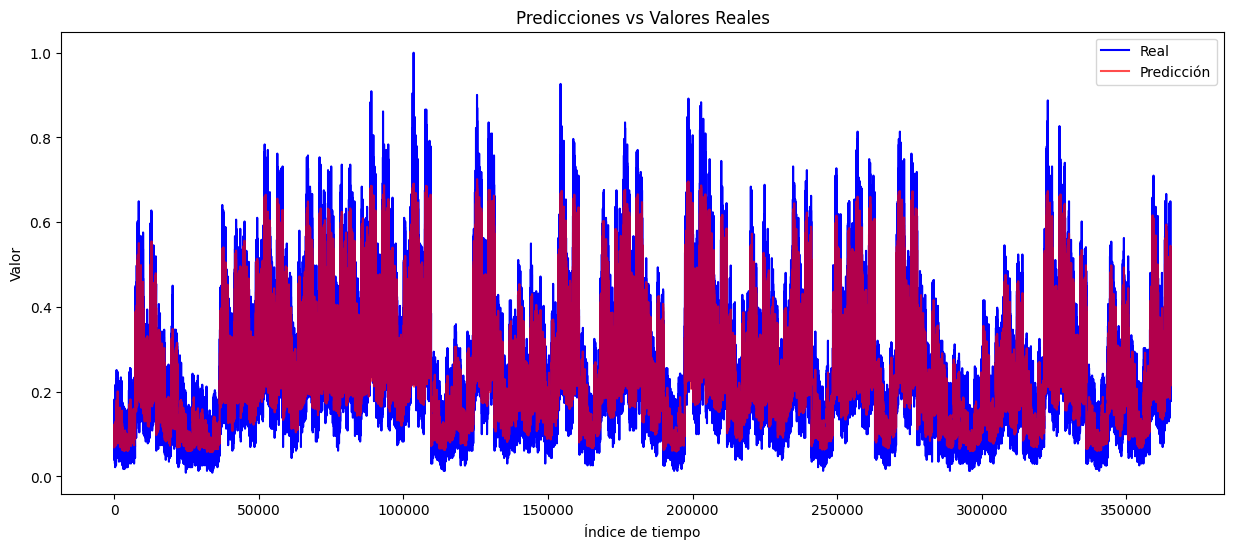

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Construcción del modelo
model = Sequential()

# Normalización por lotes antes de las capas LSTM
model.add(BatchNormalization(input_shape=(X_train.shape[1], 1)))

# Aumento en el número de unidades, adición de más capas LSTM y aumento del dropout
model.add(LSTM(units=100, return_sequences=True))  # Aumento a 100 unidades
model.add(Dropout(0.5))  # Aumento al 50%
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.5))  # Aumento al 50%
model.add(LSTM(units=50))
model.add(Dropout(0.5))  # Aumento al 50%

# Capa de salida
model.add(Dense(units=1))

# Compilación del modelo con una tasa de aprendizaje modificada
adam_optimizer = Adam(lr=0.001)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Entrenamiento del modelo con más épocas y un tamaño de lote diferente
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Realizar predicciones
predictions = model.predict(X_test)

# Calcular las métricas de evaluación
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # RMSE

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Crear una figura y un set de subplots
plt.figure(figsize=(15,6))

# Dibujar los valores reales
plt.plot(y_test, color='blue', label='Real')

# Dibujar las predicciones
plt.plot(predictions, color='red', alpha=0.7, label='Predicción')

# Títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.legend()

# Mostrar la gráfica
plt.show()


8. Forescasting

9. Visualización

10. Interpretabilidad del modelo